In [ ]:
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
backend = AerSimulator.from_backend(FakeParis())
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#visualization
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp,partial_trace
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit.extensions import UnitaryGate
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options, Sampler
from qiskit.test.reference_circuits import ReferenceCircuits
from qiskit.transpiler import CouplingMap
from qiskit.providers.aer import extensions

In [4]:

# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="b58a80862cd6d4e3f8618d0fb10c85a7415315bcf55dd407e498ce33bdd4709623e266b4fdee952700733135cd2fa847c7bffa65966a4efb0aa2ae6a4ad7b583", overwrite=True)

Optimization levels (Error Suppression):
    3 = Dynamical Decoupling 
    
Mitigation levels (Error mitigation):
    1 = T-REx (twirled readout extinction)
    2 = ZNE (zero-noise extrapolation)
    3 = PEC (probability error cancellation)


Typical call to job:

service = QiskitRuntimeService(channel="ibm_quantum")
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # optimization
options.resilience_level = 0  # mitigation

with Session(service=service, backend=backend_simulator) as session:
    estimator_sim = Estimator(session=session, options=options)
    job_sim = estimator_sim.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_sim.job_id)
    print(job_sim.result())

In [235]:


#need to specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("simulator_statevector")


In [125]:
def generate_pauli(n, i, j):
    if n <= 0 or i < 0 or j < 0 or i >= n or j >= n:
        raise ValueError("Invalid input values")
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position i and j
    pauli_str_list = list(pauli_str)
    pauli_str_list[i] = "Z"
    pauli_str_list[j] = "Z"
    pauli_str = "".join(pauli_str_list)
    op1 = SparsePauliOp(pauli_str, coeffs=[1])
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position i
    pauli_str_list = list(pauli_str)
    pauli_str_list[i] = "Z"
    pauli_str = "".join(pauli_str_list)
    op2 = SparsePauliOp(pauli_str, coeffs=[1])
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position j
    pauli_str_list = list(pauli_str)
    pauli_str_list[j] = "Z"
    pauli_str = "".join(pauli_str_list)
    op3 = SparsePauliOp(pauli_str, coeffs=[1])

    

    return op1,op2,op3

In [150]:
#Circuit parameters
n=4
h=1
J=1.1
tau=1

layers=20
k=1
#Initialize qcirc and qstate
qc = QuantumCircuit(n)
QuantumCircuit.initialize(qc,'++++',[0,1,2,3])
sigma_z= np.array([[1,0],[0,-1]])
#prepare ancilla
#qc.h(0)
#creation of controlled unitary
#cu_gate = UnitaryGate(sigma_z, label='CU') #this gate will have to be the whole evolution circuit 

# Apply the controlled unitary operation with control qubit 0 and target qubit 1
#qc.append(cu_gate.control(), [0, 1])
qc.barrier(range(n))
#anti-controlled operation


m=0
while m<layers:
    for i in range(n):
        qc.rx(tau*h,i)
    for j in range(n//2):
        qc.rzz(tau*J, 2*j,2*j+1)
    for j in range(n//2):
        if j == (n//2 - 1):
                qc.rzz(tau*J, 2*j+1,0)
                break
        qc.rzz(tau*J, 2*j+1,2*j+2)
    qc.barrier(range(n))
    m+=1
    
    
#anti_gate = cu_gate.control(ctrl_state='0')
#qc.append(anti_gate, [0, j+1])
qc.barrier(range(n))

basis_gates=['cx', 'id', 'rz', 'x', 'sx']
qcc=transpile(qc, basis_gates=basis_gates, optimization_level=3)

In [ ]:
#Circuit parameters
n=2
h=1
J=1.1
tau=0.1



sigma_z= np.array([[1,0],[0,-1]])
sizes = np.array([2,4,8,10],dtype=int)
bipartite_entropies = np.zeros((len(sizes),len(layers)),dtype=complex)
renyi = np.zeros((len(sizes),len(layers)),dtype=complex)

for k,size in enumerate(tqdm(sizes)):
    print(k)
    print("size ",size)
    layers = np.array([j for j in range(1,15*size)])
    subsystem = [j for j in range(0,size//2)]
    print("subsystem ",subsystem)
    for s,l in enumerate(layers):
        string = "+" * size
        qc = QuantumCircuit(size)
        QuantumCircuit.initialize(qc,string)
        
        m=0
        while m<l:
            for i in range(size):
                qc.rx((tau)*h,i)
            for j in range(size//2):
                qc.rzz((tau)*J, 2*j,2*j+1)
            for j in range(size//2):
                if j == (size//2 - 1):
                        qc.rzz(tau*J, 2*j+1,0)
                        break
                qc.rzz((tau)*J, 2*j+1,2*j+2)
            qc.barrier(range(size))
            m+=1
        
    
    ############################################################################    
    
        #access density matrix  
        rho = DensityMatrix(qc)
        #print("DM", rho)
        reduced_rho=partial_trace(rho, subsystem)
        #print(reduced_rho)
       # print(reduced_rho)
        rho_reg = reduced_rho + 1e-15 * np.identity(2**(size//2))  # Add regularization
        #von_neumann_entropy = -np.trace(rho_reg @ np.log(rho_reg))
        
        # Find the eigenvalues of the reduced density matrix
        #eigenvalues, _ = np.linalg.eig(rho_reg)
        # Perform a singular value decomposition (SVD) on the density matrix
        U, S, V = np.linalg.svd(rho_reg)

        # Compute the eigenvalues of the reduced density matrix
        # In this example, we assume a bipartite system where one subsystem is traced out
        #eigenvalues = S ** 2
       
        
        
        # Compute the entanglement entropy
        entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
        renyi[k,s]=-np.log(DensityMatrix.purity(rho_reg))
        bipartite_entropies[k,s]=entanglement_entropy#entanglement_entropy
        #print("layers", l,"EE",entanglement_entropy,"RE",renyi[s])
    ############################################################################    
        

 25%|███████████████████▎                                                         | 1/4 [00:00<00:00,  8.44it/s]

0
size  2
subsystem  [0]
1
size  4
subsystem  [0, 1]


 50%|██████████████████████████████████████▌                                      | 2/4 [00:00<00:01,  1.97it/s]

2
size  8
subsystem  [0, 1, 2, 3]


 75%|█████████████████████████████████████████████████████████▊                   | 3/4 [02:11<00:59, 59.77s/it]

3
size  10
subsystem  [0, 1, 2, 3, 4]


100%|████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 306.93it/s]


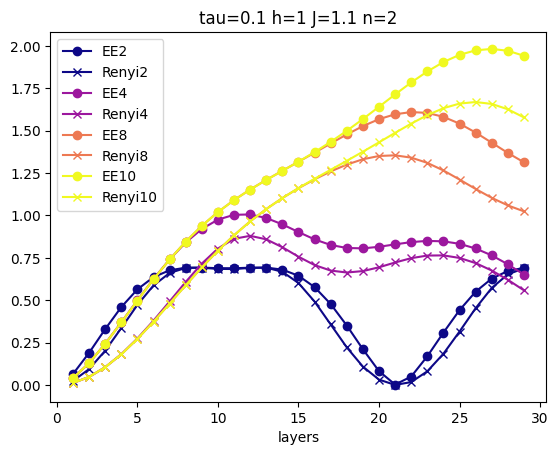

In [196]:
from itertools import cycle
colormap1 = plt.cm.plasma
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(sizes))))
colormap2 = plt.cm.plasma
color_cycle2 = cycle(colormap2(np.linspace(0, 1, len(sizes))))


for k,size in enumerate(tqdm(sizes)):
    color1 = next(color_cycle1)
    color2 = next(color_cycle2)
    plt.plot(layers, bipartite_entropies[k],'-o', c=color1,label='EE'+str(size))
    plt.plot(layers, renyi[k],'-x', c=color1,label='Renyi'+str(size))
    
plt.title('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n='+str(n))
plt.xlabel('layers')
plt.legend()   
    

In [174]:
k=1
plt.plot(layers, bipartite_entropies[k],'-o', c='m',label='EE'+str(size))
plt.plot(layers, renyi[k],'-x', c='g',label='Renyi'+str(size))
    

IndexError: index 1 is out of bounds for axis 0 with size 1

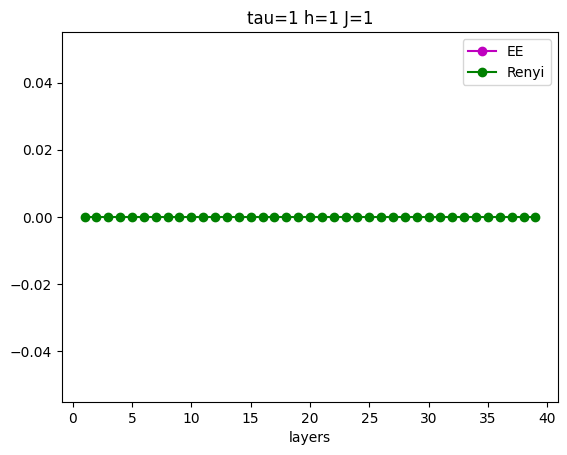

In [58]:
plt.plot(layers, bipartite_entropies,'-o', c='m',label='EE')
plt.plot(layers, renyi,'-o', c='g',label='Renyi')
plt.xlabel('layers')
plt.title('tau='+str(tau)+' h='+str(h)+' J='+str(J))
plt.legend()

In [8]:
#settings job execution
service = QiskitRuntimeService(channel="ibm_quantum")
options = Options()
options.execution.shots = 8000
options.optimization_level = 3  # optimization
options.resilience_level = 2  # mitigation

#coupling map for Simulator 
cmap = CouplingMap()
for i in range(n):
    if i == n-1:
        cmap.add_edge(n-1,0)
    else:
        cmap.add_edge(i, i + 1)
    

In [196]:
print(cmap)

[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 0]]


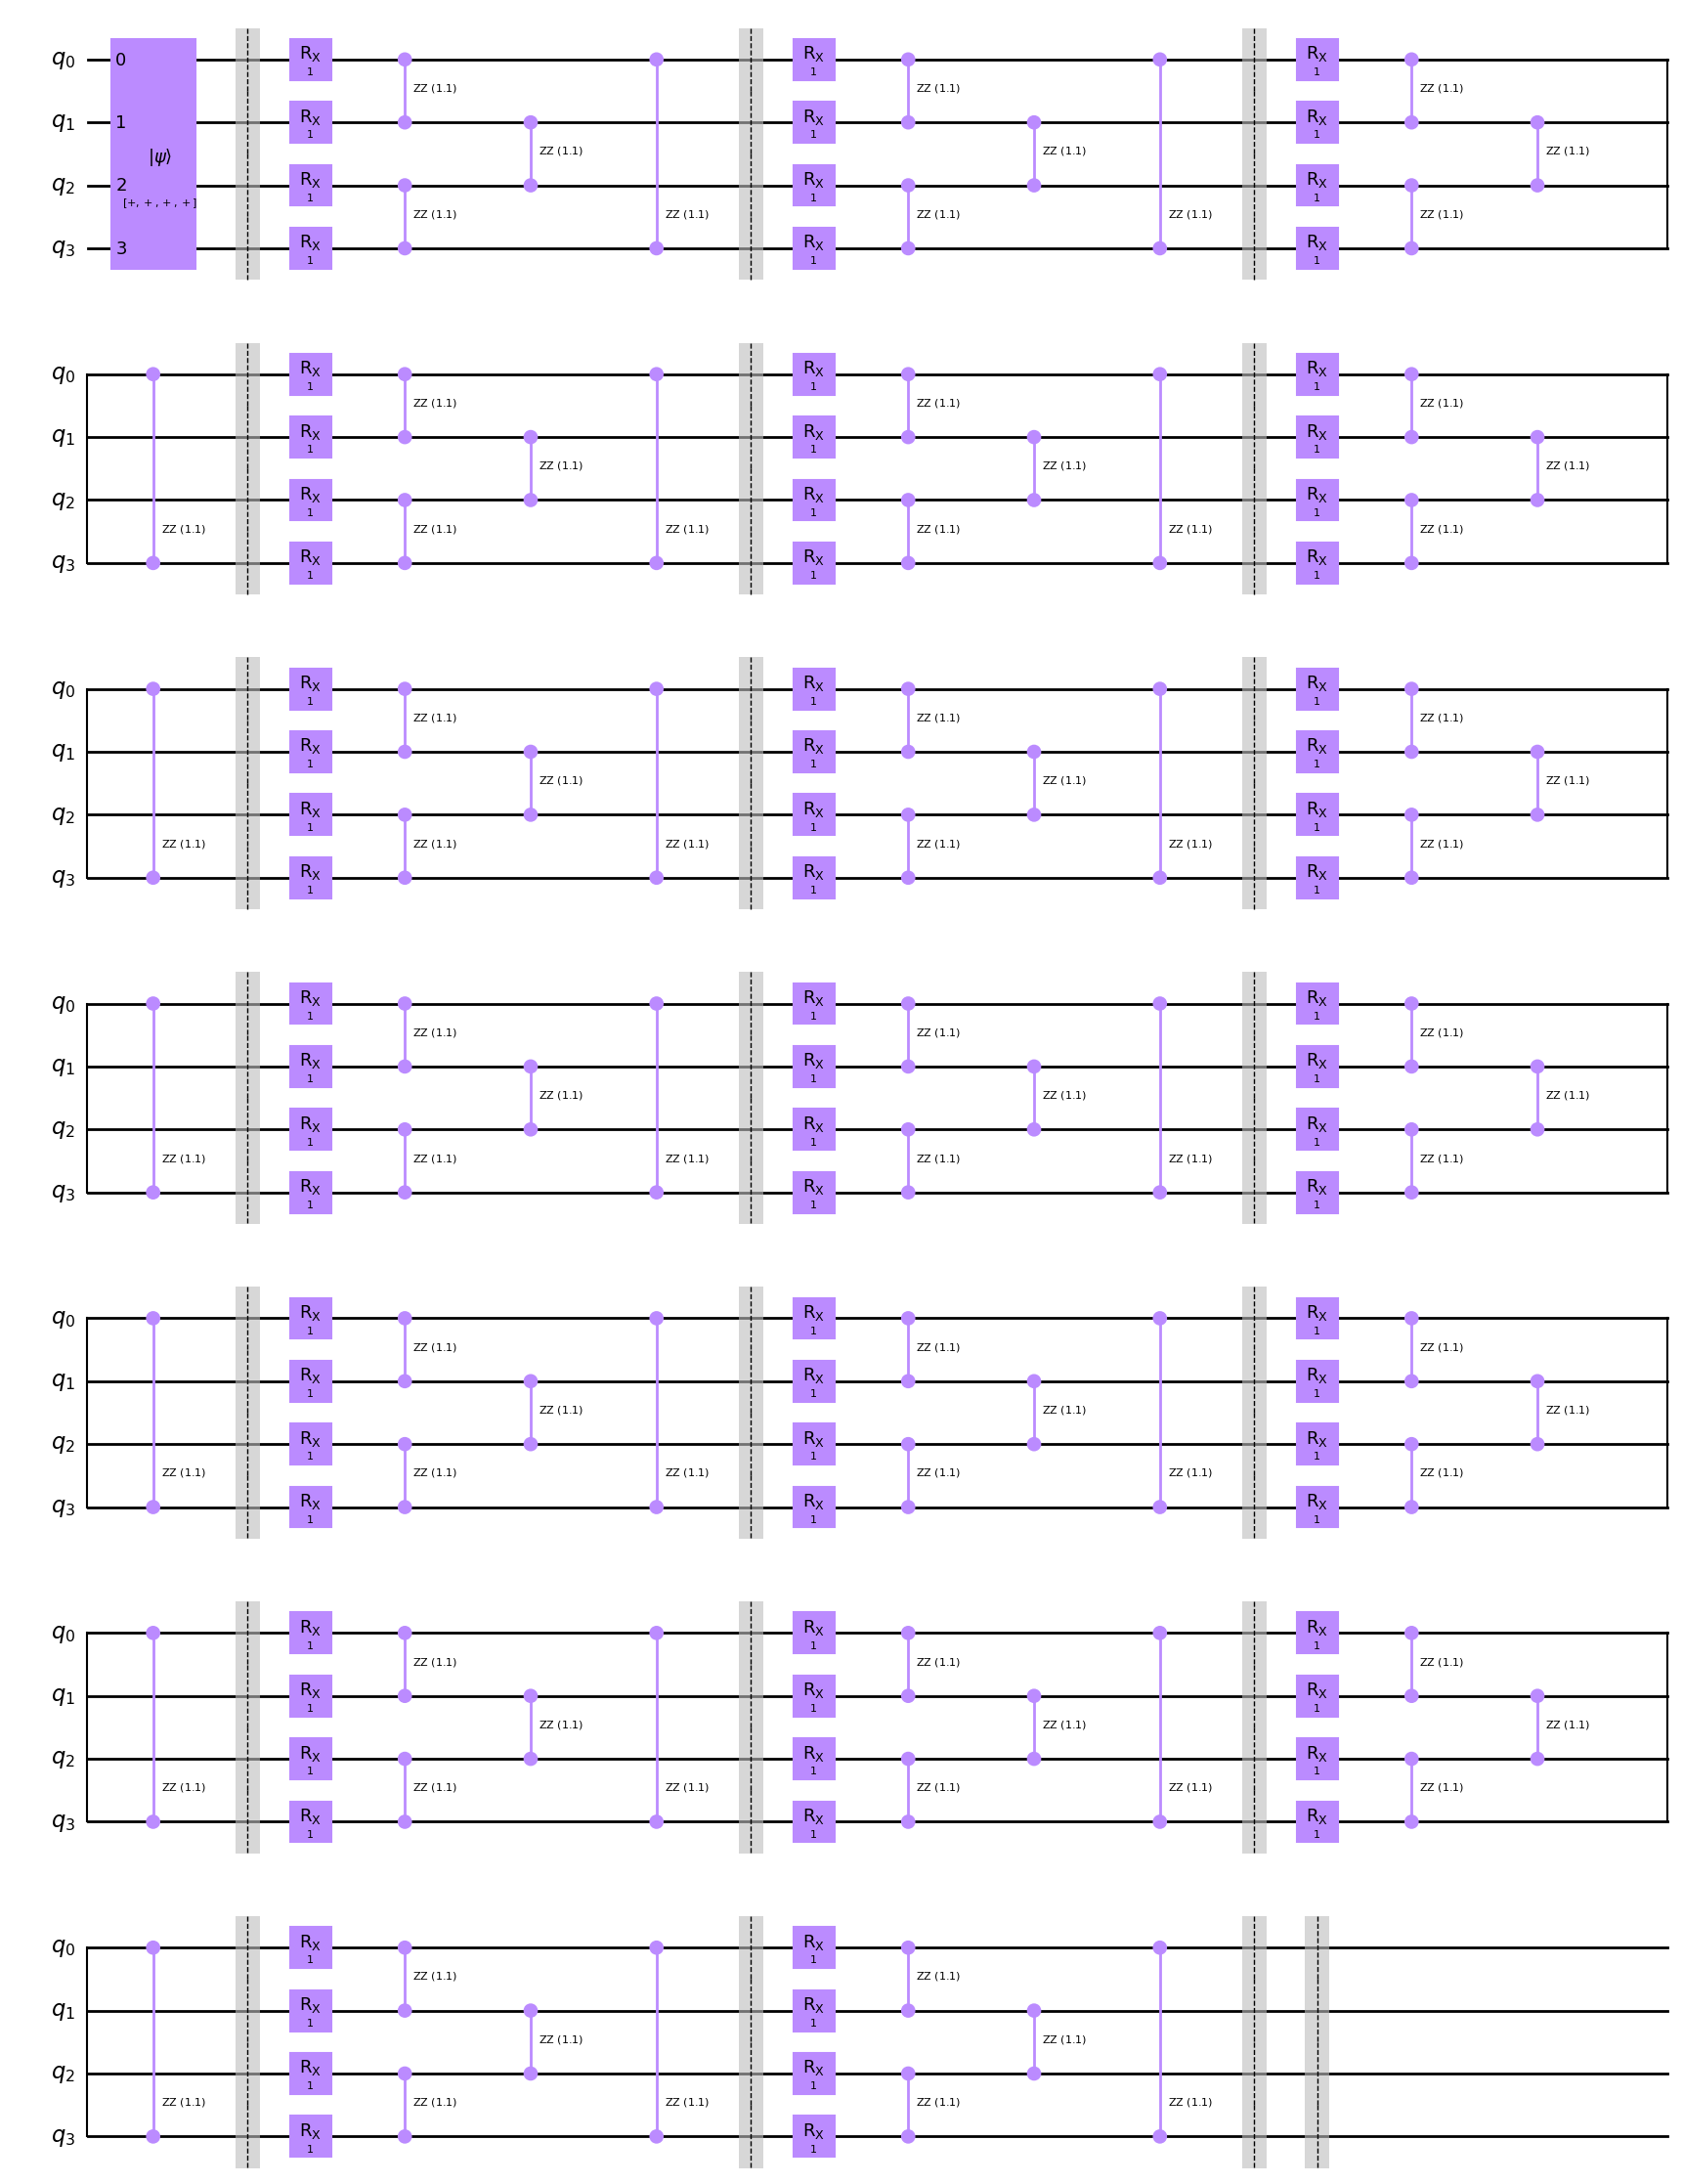

In [151]:
dispcolors = {'cx':('#426299', '#000000'),
              'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}

qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:59<00:00, 42.81s/it]


Text(0.5, 1.0, 'TFIM Spatial Correlation $C_{ij}(r)$, h=1, J=1.1, layers=20')

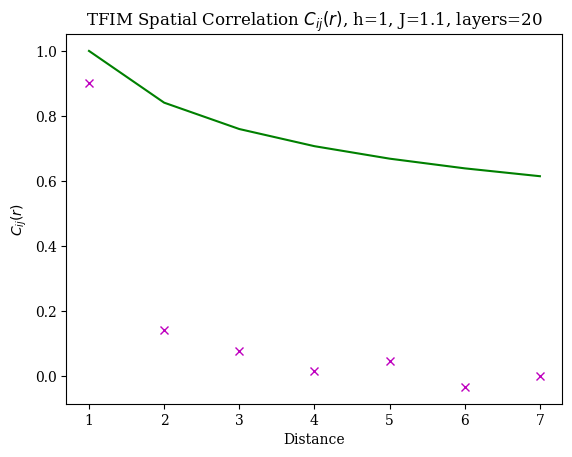

In [240]:
#computation of spatial correlation functions for incresing distance
correlations = np.zeros(n-1,dtype=complex)
for m in tqdm(range(1,n)):
    op1,op2,op3 = generate_pauli(n, 0, m)
    with Session(service=service, backend=backend) as session:
        estimator_sim = Estimator(session=session, options=options)
        job_sim = estimator_sim.run(circuits=[qcc]*3, observables=[op1,op2,op3], coupling_map=cmap)
        values = job_sim.result().values
        correlations[m-1]=2*values[0]-values[1]*values[2]
distances=np.array([i for i in range(1,8)], dtype=float)
plt.plot(distances, correlations,'x', c='m')
plt.plot(distances, 1/distances**(1/4),c='g')
plt.rcParams["font.family"] = "serif"
plt.xlabel(r'Distance')
plt.ylabel(r'$C_{ij}(r)$')
plt.title(r"TFIM Spatial Correlation $C_{ij}(r)$, h="+str(h)+", J="+str(J)+", layers="+str(layers))
#plt.savefig("TFIM Spatial Correlation $C_{ij}(r)$, h="+str(h)+", J=1,1 , layers="+str(layers)+"op3mit2", bbox_inches='tight')

In [222]:
for m in tqdm(range(1,n)):
    op1,op2,op3 = generate_pauli(n, 0, m)
    print(op1,op2,op3)


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1181.49it/s]

SparsePauliOp(['ZZIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['IZIIIIII'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZIZIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['IIZIIIII'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZIIZIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['IIIZIIII'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZIIIZIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['IIIIZIII'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZIIIIZII'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['IIIIIZII'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZIIIIIZI'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j

In [168]:
from scipy.optimize import curve_fit


def my_curve_function(x, a):
    return 1/x**a

params, covariance = curve_fit(my_curve_function, distances, correlations, method='trf')

/home/alberto/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:626: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
